In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

üî¨ Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
üß¨ Detecting CUDA devices‚Ä¶
‚úÖ [GPU 0] NVIDIA H100 80GB HBM3
    ‚Ä¢ Total memory: 79.1 GB
    ‚Ä¢ Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

üîñ Version: 1.7.6rc1   üìö Tutorials: https://omicverse.readthedocs.io/
‚úÖ plot_set complete.



- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [2]:
adata1=ov.read('data/neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('data/neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('data/neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [3]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs √ó n_vars = 27423 √ó 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## geneformer v2

we need to download the model checkpoint from here: https://huggingface.co/ctheodoris/Geneformer/tree/main/Geneformer-V2-104M

In [6]:
#!/usr/bin/env python3
import os
import requests

urls = [
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/model.safetensors?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/config.json?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/generation_config.json?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/training_args.bin?download=true",
    
]

output_dir = "llm_model/models/geneformer/Geneformer-V2-104M"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    filename = url.split('?')[0].split('/')[-1]
    filepath = os.path.join(output_dir, filename)
    
    print(f"Downloading {filename} ...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    with open(filepath, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Saved to {filepath}")

print("All files downloaded successfully.")


Saved to llm_model/models/geneformer/Geneformer-V2-104M/model.safetensors
Saved to llm_model/models/geneformer/Geneformer-V2-104M/config.json
Saved to llm_model/models/geneformer/Geneformer-V2-104M/generation_config.json
Saved to llm_model/models/geneformer/Geneformer-V2-104M/training_args.bin
All files downloaded successfully.


In [7]:
#!/usr/bin/env python3
import os
import requests

urls = [
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/ensembl_mapping_dict_gc104M.pkl?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_median_dictionary_gc104M.pkl?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_name_id_dict_gc104M.pkl?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/token_dictionary_gc104M.pkl?download=true",
]

output_dir = "llm_model/models/geneformer"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    filename = url.split('?')[0].split('/')[-1]
    filepath = os.path.join(output_dir, filename)
    
    print(f"Downloading {filename} ...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    with open(filepath, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Saved to {filepath}")

print("All files downloaded successfully.")


Saved to llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl
Saved to llm_model/models/geneformer/gene_median_dictionary_gc104M.pkl
Saved to llm_model/models/geneformer/gene_name_id_dict_gc104M.pkl
Saved to llm_model/models/geneformer/token_dictionary_gc104M.pkl
All files downloaded successfully.


In [8]:
manager = ov.llm.SCLLMManager(
    model_type='geneformer',
    model_version='V2',  
    device='cuda',
    
)
#analysis/omic_test/llm_model/Geneformer/geneformer/ensembl_mapping_dict_gc104M.pkl
manager.model.load_model(
    'llm_model/models/geneformer/Geneformer-V2-104M',
    gene_median_file='llm_model/models/geneformer/gene_median_dictionary_gc104M.pkl',
    token_dictionary_file='llm_model/models/geneformer/token_dictionary_gc104M.pkl',
    gene_mapping_file='llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl'
)

‚úì Geneformer model initialized (version: V2)
üì• Loading Geneformer model
  Stored gene_median_file: llm_model/models/geneformer/gene_median_dictionary_gc104M.pkl
  Stored token_dictionary_file: llm_model/models/geneformer/token_dictionary_gc104M.pkl
  Stored gene_mapping_file: llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl
‚úì Tokenizer initialized with external dictionary files
  Gene median: gene_median_dictionary_gc104M.pkl
  Token dictionary: token_dictionary_gc104M.pkl
‚úì Geneformer model loaded successfully
  Version: V2


In [9]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None,target_sum=1e4)
adata

Begin robust gene identification
After filtration, 13953/13953 genes are kept.     Among 13953 genes, 13953 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'HBB', 'MALAT1', 'IGHA1', 'IGHM', 'HBA2', 'IGLC1', 'IGLC2', 'IGLC3']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 3.0509798526763916 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs √ó n_vars = 27423 √ó 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [10]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs √ó n_vars = 27423 √ó 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

### zero-shot embedding

In [11]:
embeddings = manager.get_embeddings(adata,max_ncells=100000)

üî¨ Data Summary:
  Cells: 27,423
  Genes: 3,000
  Batches: 3
    s3d7: 11,230 cells
    s2d1: 10,258 cells
    s1d3: 5,935 cells
üß¨ Starting get_embeddings...
  cells: 27,423
  genes: 3,000
üîÑ Preprocessing data for Geneformer...
normalizing counts per cell
    finished (0:00:00)
‚úì  Normalized total counts
üîÑ Preprocessing completed: 27423 cells √ó 3000 genes
üîÆ  Extracting cell embeddings with Geneformer...
‚ÑπÔ∏è  Using stored dictionary files: ['gene_median_file', 'token_dictionary_file', 'gene_mapping_file']
üìä Converting AnnData to Geneformer format...
  üîÑ Preparing data for Geneformer tokenization
  üîÑ Adding ensembl_id column to adata.var
  ‚ö†Ô∏è Using gene symbols as ensembl_id (may cause filtering)
    ‚ÑπÔ∏è Geneformer works best with Ensembl gene IDs
  üìä Gene mapping analysis:
  üìã Sample gene symbols in your data: ['LINC00115', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MIB2', 'MMP23B', 'NADK', 'AL139246.5', 'TNFRSF14-AS1']
  üìã Total genes in datas

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at llm_model/models/geneformer/Geneformer-V2-104M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  üìä Original indices range: 0 to 27422
  üìä First 10 original_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  üìä Expected sequential order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  ‚úÖ Dataset cells are in ORIGINAL order (not sorted by length)
  üîç Position mapping: pos[0]->cell0, pos[1]->cell1, pos[2]->cell2
üîß Initializing EmbExtractor...
  üìã Tokenizer uses special_token: True
  EmbExtractor config: {'model_type': 'CellClassifier', 'num_classes': 3, 'emb_mode': 'cls', 'cell_emb_style': 'mean_pool', 'filter_data': {}, 'max_ncells': 100000, 'emb_layer': 0, 'emb_label': [], 'labels_to_plot': [], 'forward_batch_size': 200, 'model_version': 'V2', 'nproc': 4, 'token_dictionary_file': 'llm_model/models/geneformer/token_dictionary_gc104M.pkl'}
  üîç EmbExtractor debugging:
     EmbExtractor <cls> token ID: 2
     Direct from file <cls> token ID: 2
     Sample tokens from dictionary: [('<pad>', 0), ('<mask>', 1), ('<cls>', 2), ('<eos>', 3), ('ENSG00000000003', 4)]
üî•  Extracting embeddings

  0%|          | 0/138 [00:00<?, ?it/s]

  ‚úÖ Embeddings extracted with preserved cell order!
‚úì  Extracted embeddings from EmbExtractor: (27423, 768)
  ‚ÑπÔ∏è Cell order information:
  üìä Embeddings are now in ORIGINAL input order (order preserved)
  üìä This is different from official Geneformer behavior (which sorts by length)
  üí° embeddings[0] corresponds to input adata cell[0], embeddings[1] to input adata cell[1], etc.
  üìã Original adata.obs.index type: <class 'pandas.core.indexes.base.Index'>
  üìã Original adata.obs.index first 5: ['CTATCCGGTGTCCGGT-1-s1d3', 'AGAAGCGGTGTCTTAG-1-s1d3', 'GGCTTGGTCTACGCAA-1-s1d3', 'AGAAGTATCTAAGCCA-1-s1d3', 'GAACGTTTCCTACGAA-1-s1d3']
  üìã Sample obs.index values: ['CTATCCGGTGTCCGGT-1-s1d3', 'AGAAGCGGTGTCTTAG-1-s1d3', 'GGCTTGGTCTACGCAA-1-s1d3']
  ‚úÖ Found cell_barcode in dataset - using real barcode mapping
  üìã First 5 barcodes from dataset: ['CTATCCGGTGTCCGGT-1-s1d3', 'AGAAGCGGTGTCTTAG-1-s1d3', 'GGCTTGGTCTACGCAA-1-s1d3', 'AGAAGTATCTAAGCCA-1-s1d3', 'GAACGTTTCCTACGAA-1-s1

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


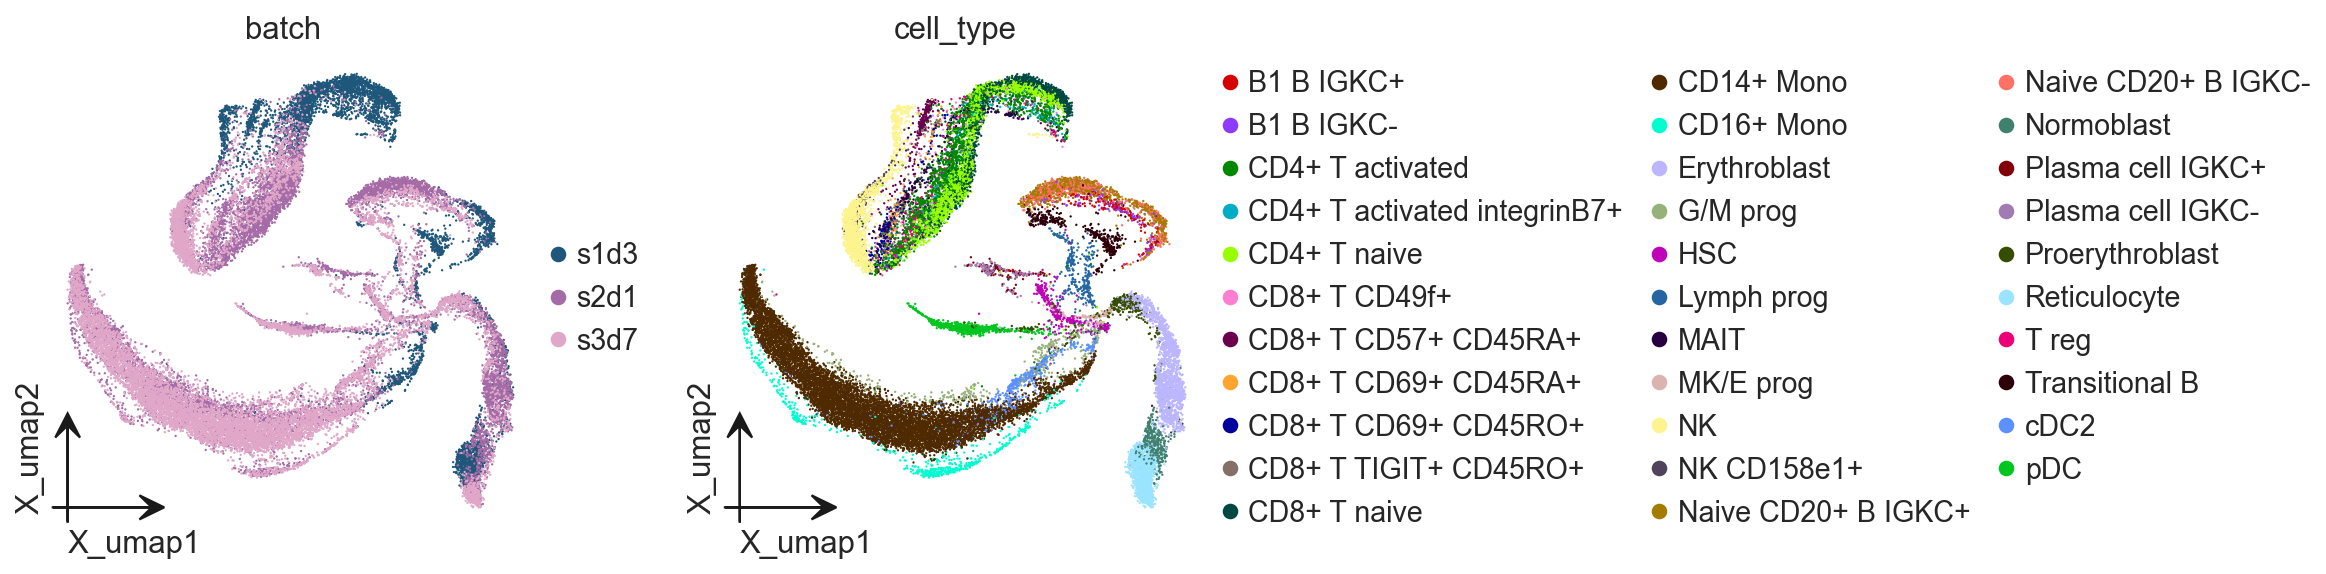

In [12]:
#adata.obsm['X_geneformer'] = df.loc[adata.obs.index,[f'emb_{i}' for i in range(0,768)]]
adata.obsm['X_geneformer'] = embeddings
sc.pp.neighbors(adata, use_rep='X_geneformer')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### fine-tune

In [13]:
reference_adata=adata[adata.obs['batch']=='s1d3']

In [14]:
reference_adata

View of AnnData object with n_obs √ó n_vars = 5935 √ó 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU', 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_geneformer', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [15]:
reference_adata.obs['celltype']=reference_adata.obs['cell_type'].copy()

In [16]:
fine_tune_results = manager.model.fine_tune(
    train_adata=reference_adata,
    epochs=10,           # 
    batch_size=32,       # 
    lr=1e-4,            # 
)

üîß Fine-tuning Geneformer for annotation task...
Cell types detected: ['CD14+ Mono', 'CD8+ T naive', 'NK', 'T reg', 'CD8+ T CD57+ CD45RA+', 'Transitional B', 'Lymph prog', 'Naive CD20+ B IGKC+', 'Normoblast', 'Reticulocyte', 'CD4+ T naive', 'CD4+ T activated', 'CD8+ T TIGIT+ CD45RO+', 'B1 B IGKC+', 'CD4+ T activated integrinB7+', 'Erythroblast', 'MAIT', 'B1 B IGKC-', 'CD8+ T CD49f+', 'Naive CD20+ B IGKC-', 'G/M prog', 'Proerythroblast', 'HSC', 'CD16+ Mono', 'cDC2', 'CD8+ T CD69+ CD45RO+', 'pDC', 'CD8+ T CD69+ CD45RA+', 'Plasma cell IGKC+', 'MK/E prog']
üîß Starting fine-tuning using simplified approach...
üìä Creating tokenized dataset...
  üîÑ Preparing data for Geneformer tokenization
  üîÑ Adding ensembl_id column to adata.var
  ‚ö†Ô∏è Using gene symbols as ensembl_id (may cause filtering)
    ‚ÑπÔ∏è Geneformer works best with Ensembl gene IDs
  üìä Gene mapping analysis:
  üìã Sample gene symbols in your data: ['LINC00115', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MIB2', 'M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at llm_model/models/geneformer/Geneformer-V2-104M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Train set: 5342 cells
  Eval set: 593 cells
üîß Initializing model for fine-tuning...


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


  ‚úÖ Model initialized with 30 classes
üîß Setting up training arguments...
üîß Initializing trainer...
üî•  Starting training...


‚úÖ Fine-tuning completed!
üîÑ  Preparing fine-tuned model for inference...
  ‚úÖ Extracted BERT base model from classification model
  ‚úÖ Fine-tuned model ready for inference


In [17]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
    max_ncells=100000
)
adata.obsm['X_geneformer_fine'] = zero_shot_results['embeddings']

üîÑ  Performing batch integration with Geneformer embeddings...
üî¨ Data Summary:
  Cells: 27,423
  Genes: 3,000
  Batches: 3
    s3d7: 11,230 cells
    s2d1: 10,258 cells
    s1d3: 5,935 cells
üß¨ Starting get_embeddings...
  cells: 27,423
  genes: 3,000
üîÑ Preprocessing data for Geneformer...
normalizing counts per cell
    finished (0:00:00)
‚úì  Normalized total counts
üîÑ Preprocessing completed: 27423 cells √ó 3000 genes
üîÆ  Extracting cell embeddings with Geneformer...
‚ÑπÔ∏è  Using stored dictionary files: ['gene_median_file', 'token_dictionary_file', 'gene_mapping_file']
üìä Converting AnnData to Geneformer format...
  üîÑ Preparing data for Geneformer tokenization
  üîÑ Adding ensembl_id column to adata.var
  ‚ö†Ô∏è Using gene symbols as ensembl_id (may cause filtering)
    ‚ÑπÔ∏è Geneformer works best with Ensembl gene IDs
  üìä Gene mapping analysis:
  üìã Sample gene symbols in your data: ['LINC00115', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MIB2', 'MMP23B', 

  0%|          | 0/138 [00:00<?, ?it/s]

  ‚úÖ Embeddings extracted with preserved cell order!
‚úì  Extracted embeddings from EmbExtractor: (27423, 768)
  ‚ÑπÔ∏è Cell order information:
  üìä Embeddings are now in ORIGINAL input order (order preserved)
  üìä This is different from official Geneformer behavior (which sorts by length)
  üí° embeddings[0] corresponds to input adata cell[0], embeddings[1] to input adata cell[1], etc.
  üìã Original adata.obs.index type: <class 'pandas.core.indexes.base.Index'>
  üìã Original adata.obs.index first 5: ['CTATCCGGTGTCCGGT-1-s1d3', 'AGAAGCGGTGTCTTAG-1-s1d3', 'GGCTTGGTCTACGCAA-1-s1d3', 'AGAAGTATCTAAGCCA-1-s1d3', 'GAACGTTTCCTACGAA-1-s1d3']
  üìã Sample obs.index values: ['CTATCCGGTGTCCGGT-1-s1d3', 'AGAAGCGGTGTCTTAG-1-s1d3', 'GGCTTGGTCTACGCAA-1-s1d3']
  ‚úÖ Found cell_barcode in dataset - using real barcode mapping
  üìã First 5 barcodes from dataset: ['CTATCCGGTGTCCGGT-1-s1d3', 'AGAAGCGGTGTCTTAG-1-s1d3', 'GGCTTGGTCTACGCAA-1-s1d3', 'AGAAGTATCTAAGCCA-1-s1d3', 'GAACGTTTCCTACGAA-1-s1

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


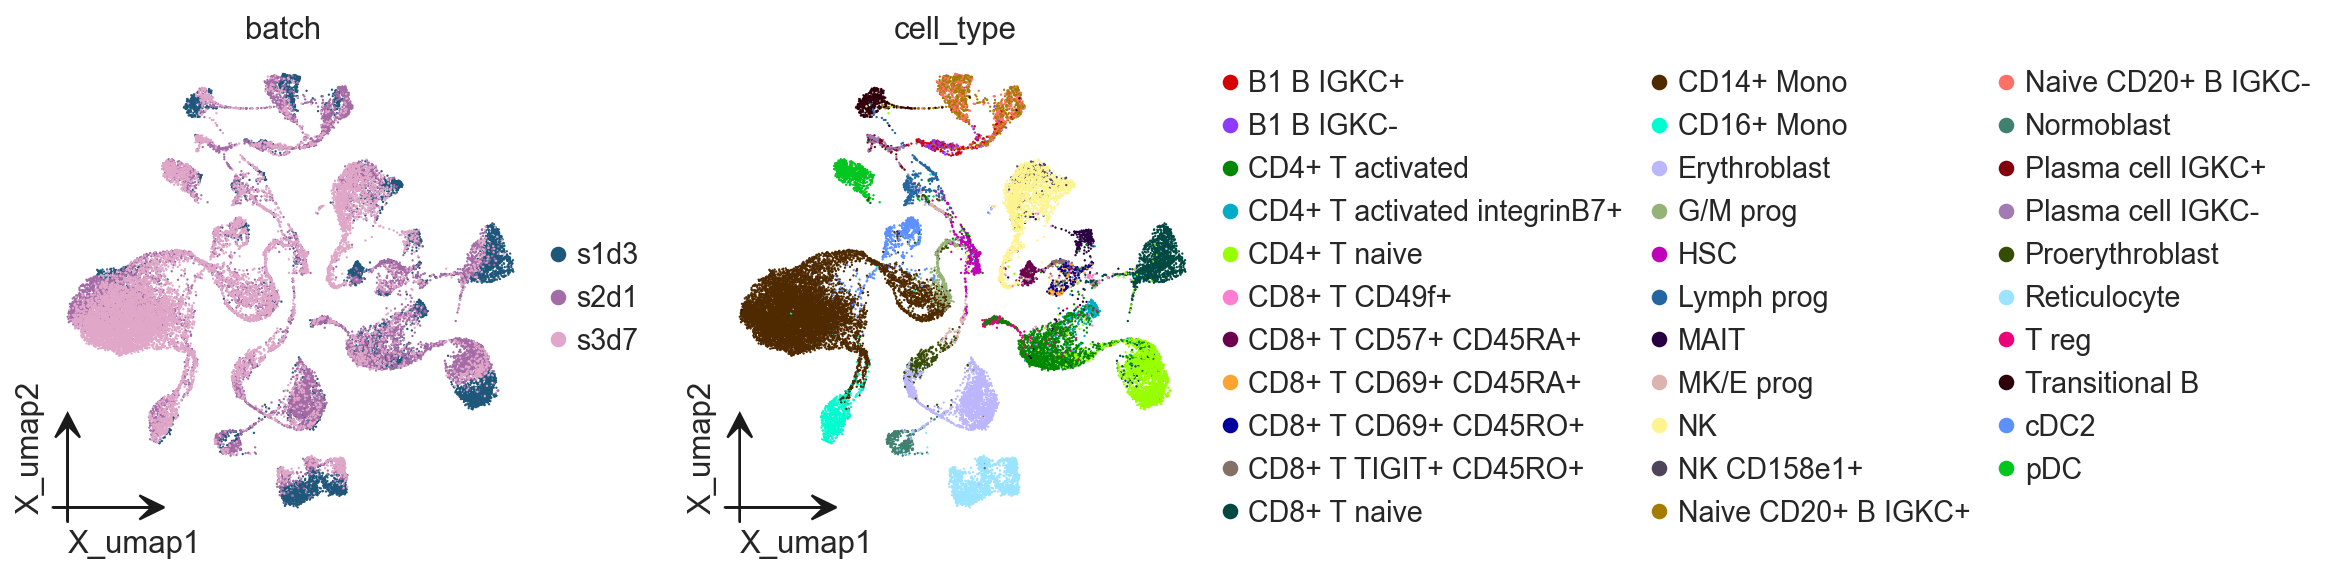

In [18]:
sc.pp.neighbors(adata, use_rep='X_geneformer_fine')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### annotation

In [19]:
results_anno = manager.model.predict(
    adata,
    task="annotation",
    max_ncells=100000
)

üîÑ Preprocessing data for Geneformer...
normalizing counts per cell
    finished (0:00:00)
‚úì  Normalized total counts
üîÑ Preprocessing completed: 27423 cells √ó 3000 genes
üîÆ  Predicting cell types with Geneformer...
üìä Preparing data for prediction...
  üîÑ Preparing data for Geneformer tokenization
  üîÑ Adding ensembl_id column to adata.var
  ‚ö†Ô∏è Using gene symbols as ensembl_id (may cause filtering)
    ‚ÑπÔ∏è Geneformer works best with Ensembl gene IDs
  üìä Gene mapping analysis:
  üìã Sample gene symbols in your data: ['LINC00115', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MIB2', 'MMP23B', 'NADK', 'AL139246.5', 'TNFRSF14-AS1']
  üìã Total genes in dataset: 3000
  üí° Attempting to map gene symbols to Ensembl IDs...
  üîÑ Proactive gene symbol mapping...
  üìã Loading gene mapping from: llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl
  ‚úì Loaded mapping dictionary with 173697 entries
  üìä Mapping results:
     ‚úÖ Mapped: 2767 genes
     ‚ùå Unm

In [20]:
adata.obs['predicted_celltype'] = results_anno['predicted_celltypes']
adata.obs['predicted_celltype_id'] = results_anno['predictions']

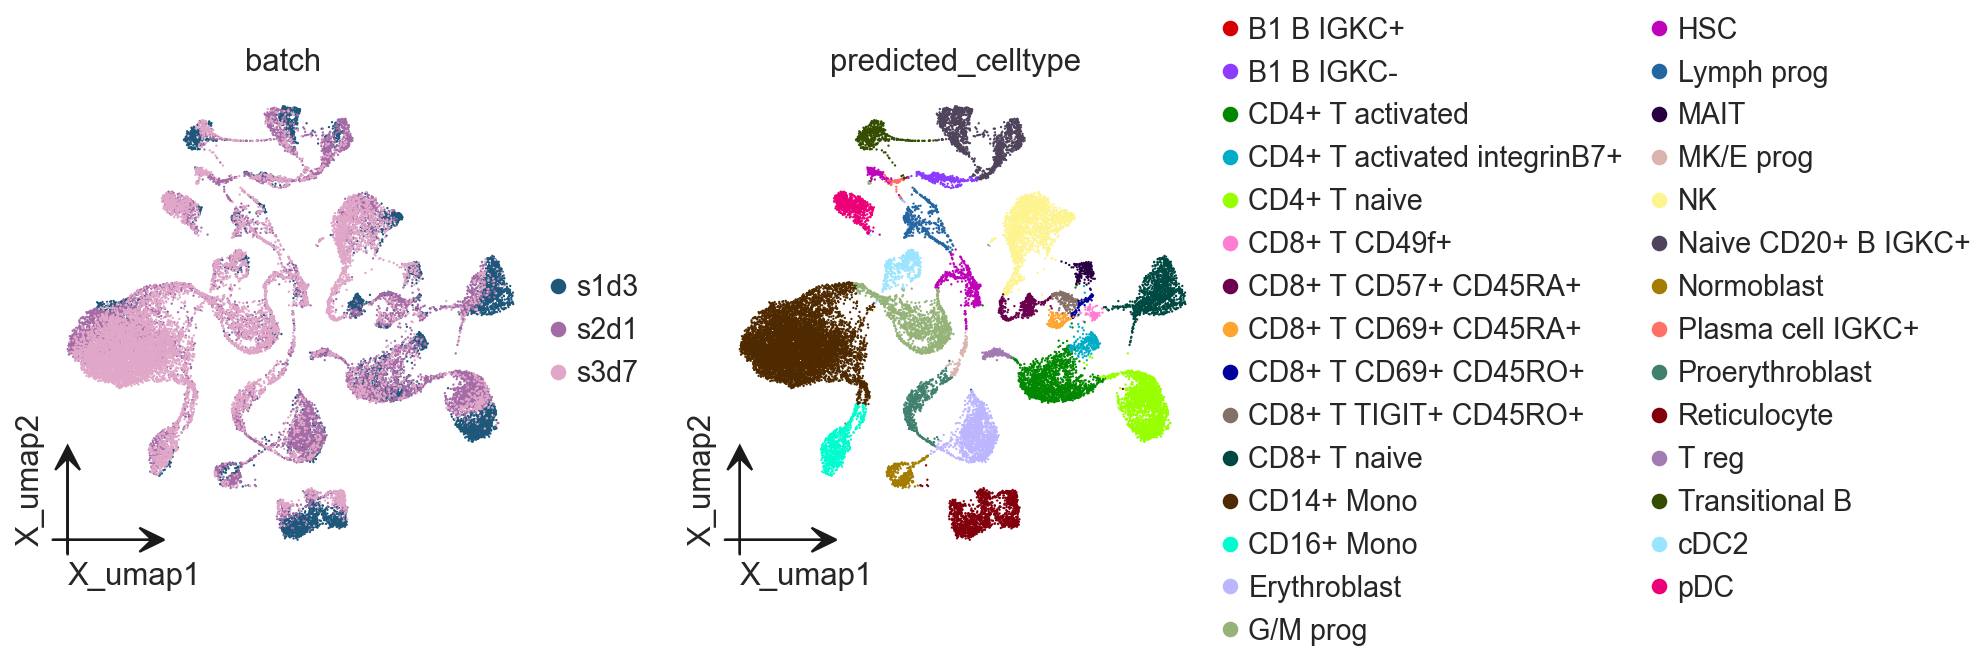

In [21]:
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'predicted_celltype']
)